In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm

torch.manual_seed(12)
seed = torch.initial_seed()
print('Used seed : {}'.format(seed))

Used seed : 12


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [3]:
N_CLASSES = 10
BATCH_SIZE = 128
NUM_EPOCHS = 90

In [4]:
# "We did not pre-process the images in any other way,
# except for subtracting the mean activity over the training set from each pixel."
 
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.47336316108703613,), (1,))  # mean computed beforehand
])

train_dataset = datasets.CIFAR10(root='../data/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = datasets.CIFAR10(root='../data/', train=False, download=True, transform=transform)

val_size = len(test_dataset) // 2      # 5000 samples for validation
test_size = len(test_dataset) - val_size  # 5000 samples for testing

# split the dataset
val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 170M/170M [00:03<00:00, 45.4MB/s] 


Extracting ../data/cifar-10-python.tar.gz to ../data/
Files already downloaded and verified


In [5]:
labels = {
	0: "airplane",
	1: "automobile",
	2: "bird",
	3: "cat",
	4: "deer",
	5: "dog",
	6: "frog",
	7: "horse",
	8: "ship",
	9: "truck"
}

In [6]:
# mean = 0
# total_samples = 0

# for images, _ in train_loader:
#     batch_samples = images.size(0)
#     total_samples += batch_samples
#     mean += images.mean() * batch_samples

# mean /= total_samples

# print("Mean per channel:", mean.item())

In [7]:
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # my input size is 3 x 32 x 32
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=7, stride=1),  # 96 x 26 x 26
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),  # section 3.3
            nn.MaxPool2d(kernel_size=3, stride=2),  # 96 x 12 x 12
            
            nn.Conv2d(96, 256, 5, padding=2),  # 256 x 12 x 12
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 256 x 5 x 5
            
            nn.Conv2d(256, 384, 3, padding=1),  # 384 x 5 x 5
            nn.ReLU(),
            
            nn.Conv2d(384, 384, 3, padding=1),  # 384 x 5 x 5
            nn.ReLU(),
            
            nn.Conv2d(384, 256, 3, padding=1),  # 256 x 5 x 5
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 256 x 2 x 2

			# classifier
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=(256 * 2 * 2), out_features=512),
            nn.ReLU(),
            
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512, out_features=512),
            nn.ReLU(),
            
            nn.Linear(in_features=512, out_features=num_classes),
        )
        self.init_bias()

    def init_bias(self):
        '''
        We initialized the weights in each layer from a zero-mean Gaussian 
        distribution with standard deviation 0.01. We initialized the neuron
        biases in the second, fourth, and fifth convolutional layers,
		as well as in the fully-connected hidden layers, with the constant 1. 
        '''
        for layer in self.net:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)
        nn.init.constant_(self.net[4].bias, 1)
        nn.init.constant_(self.net[10].bias, 1)
        nn.init.constant_(self.net[12].bias, 1)
        nn.init.constant_(self.net[17].bias, 1)
        nn.init.constant_(self.net[20].bias, 1)

    def forward(self, x):
        return  self.net(x)


In [8]:
def train(model, optimizer, criterion, dataloader):
	num_batches = len(dataloader)

	model.train()
	total_loss = 0

	for X, y in dataloader:
		X, y = X.to(device), y.to(device)

		optimizer.zero_grad()
		pred = model(X)  # forward pass
		loss = criterion(pred, y)  # calculate loss
		loss.backward()  # backward pass
		optimizer.step()  # update parameters
		total_loss += loss.item()  # tracking

	avg_loss = total_loss / num_batches
	return avg_loss

In [9]:
def evaluate(model, criterion, dataloader):
    model.eval()
    total_loss = 0.0
    num_batches = len(dataloader)
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            loss = criterion(pred, y)
            total_loss += loss.item()
            
            # accuracy
            _, predicted = torch.max(pred, dim=1)
            total_correct += (predicted == y).sum().item()
            total_samples += y.size(0)
            
    avg_loss = total_loss / num_batches
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

In [10]:
alexnet = AlexNet(N_CLASSES).to(device)
sum(p.numel() for p in alexnet.parameters() if p.requires_grad)

4519050

In [11]:
'''
We trained our models using stochastic gradient descent
with a batch size of 128 examples, momentum of 0.9, and
weight decay of 0.0005.
'''
# original implementation doesnt seem to train
# optimizer = optim.SGD(params=alexnet.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
optimizer = optim.Adam(params=alexnet.parameters(), lr=0.0001)

'''
The heuristic which we followed was to divide the learning rate by 10 when 
the validation error rate stopped improving with the current learning rate. 
The learning rate was initialized at 0.01
'''
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.1,
    patience=2,
    threshold=1e-6,
    threshold_mode="rel",
    cooldown=0,
    min_lr=1e-8
)

#  Our network maximizes the multinomial logistic regression
criterion = nn.CrossEntropyLoss()

In [12]:
class EarlyStopping():
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # reset counter if validation loss improves
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [13]:
train_losses = []
val_losses = []
accuracies = []
early_stopping = EarlyStopping(patience=5, min_delta=1e-6)

for epoch in range(NUM_EPOCHS):
    train_loss = train(alexnet, optimizer, criterion, train_loader)
    train_losses.append(train_loss)

    val_loss, accuracy = evaluate(alexnet, criterion, val_loader)
    val_losses.append(val_loss)
    accuracies.append(accuracy)
    scheduler.step(val_loss)
    
    print(
    f"{epoch+1}/{NUM_EPOCHS}, "
    f"Training Loss: {train_loss:.4f}, "
    f"Validation Loss: {val_loss:.4f}, "
    f"Validation Accuracy: {accuracy:.4f}, "
    f"Learning Rate: {scheduler.get_last_lr()}"
    )

    # check early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        break
    
torch.save(alexnet.state_dict(), f"alexnet.pt")

1/90, Training Loss: 2.1474, Validation Loss: 1.8811, Validation Accuracy: 0.2742, Learning Rate: [0.0001]
2/90, Training Loss: 1.7718, Validation Loss: 1.6529, Validation Accuracy: 0.3808, Learning Rate: [0.0001]
3/90, Training Loss: 1.6097, Validation Loss: 1.5249, Validation Accuracy: 0.4336, Learning Rate: [0.0001]
4/90, Training Loss: 1.5230, Validation Loss: 1.4493, Validation Accuracy: 0.4704, Learning Rate: [0.0001]
5/90, Training Loss: 1.4459, Validation Loss: 1.3796, Validation Accuracy: 0.4966, Learning Rate: [0.0001]
6/90, Training Loss: 1.3725, Validation Loss: 1.2839, Validation Accuracy: 0.5256, Learning Rate: [0.0001]
7/90, Training Loss: 1.3121, Validation Loss: 1.2938, Validation Accuracy: 0.5366, Learning Rate: [0.0001]
INFO: Early stopping counter 1 of 5
8/90, Training Loss: 1.2529, Validation Loss: 1.2091, Validation Accuracy: 0.5714, Learning Rate: [0.0001]
9/90, Training Loss: 1.1968, Validation Loss: 1.1502, Validation Accuracy: 0.5862, Learning Rate: [0.0001]
1

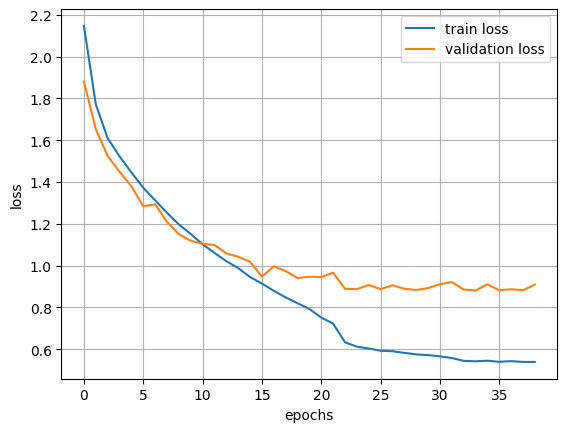

In [14]:
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid(True)
plt.legend()
plt.show()

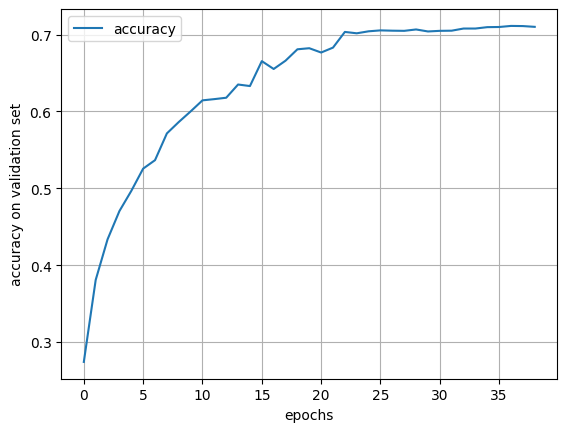

In [15]:
plt.plot(accuracies, label="accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy on validation set")
plt.grid(True)
plt.legend()
plt.show()

In [18]:
test_loss, test_acc = evaluate(alexnet, criterion, test_loader)
print(f"Test loss: {test_loss}, test accuracy: {test_acc}")

Test loss: 0.8237404976040125, test accuracy: 0.724


Test loss: 0.8237404976040125, test accuracy: 0.724